In [ ]:
!pip install transformers datasets
!pip install --upgrade datasets fsspec s3fs

INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 112.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas

In [ ]:
import re
from collections import Counter
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from datasets import load_dataset

In [ ]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

for param in model.parameters():
    param.requires_grad = False


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Use eos_token as pad_token to enable padding without adding new tokens to the vocab.
# This allows batching with padding=True and ensures the model ignores padding in the loss.
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

In [ ]:
# Load Wikitext-2 dataset
ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
texts = ds["text"]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
# Tokenize the text into word-like units and extract all n-grams of size n
def get_ngrams(text, n):
    toks = re.findall(r"\w+|\S", text.lower())
    return zip(*(toks[i:] for i in range(n)))

# Count frequency of all bigrams,trigrams, quadgrams in the dataset
bigrams = Counter()
trigrams = Counter()
quadgrams = Counter()

for txt in texts:
    bigrams.update(" ".join(g) for g in get_ngrams(txt, 2))
    trigrams.update(" ".join(g) for g in get_ngrams(txt, 3))
    quadgrams.update(" ".join(g) for g in get_ngrams(txt, 4))

In [ ]:
#HERE WE SET HOW MANY N GRAMS WE WANT
TOP_K_BIGRAMS = 100000
TOP_K_TRIGRAMS = 100000
TOP_K_QUADGRAMS = 100000

# pick top-k most frequent ngrams
bigram_tokens = [g for g, _ in bigrams.most_common(TOP_K_BIGRAMS)]
trigram_tokens = [g for g, _ in trigrams.most_common(TOP_K_TRIGRAMS)]
quadgram_tokens = [g for g,_ in quadgrams.most_common(TOP_K_QUADGRAMS)]

# Print how many n-grams were selected
print(f"Selected {len(bigram_tokens)} bigrams, {len(trigram_tokens)} trigrams and {len(quadgram_tokens)} quadgrams.")

# Map each frequent ngram to a unique pseudo-token
bigram_to_token = {phrase: f"<BI_{i}>" for i, phrase in enumerate(bigram_tokens)}
trigram_to_token = {phrase: f"<TRI_{i}>" for i, phrase in enumerate(trigram_tokens)}
quadgram_to_token = {phrase: f"<QUA_{i}>" for i, phrase in enumerate(quadgram_tokens)}

# Combine all pseudo-tokens into a single list to be added to the tokenizer
new_tokens = list(bigram_to_token.values()) + list(trigram_to_token.values()) + list(quadgram_to_token.values())

# Save the current vocabulary size to use as the index offset for n-gram tokens
bi_offset = tokenizer.vocab_size

# Add the new pseudo-tokens to the tokenizer's vocabulary
tokenizer.add_tokens(new_tokens)

# Resize the model's embedding layer to match the new vocabulary size
model.resize_token_embeddings(len(tokenizer))

# map phrases to token ids using the original tokenizer (before pseudo-tokens are used)
# This mapping is used to initialize the n-gram embeddings from the base model
bigram_token_ids = {phrase: tokenizer.encode(phrase, add_special_tokens=False)
                    for phrase in bigram_tokens}
trigram_token_ids = {phrase: tokenizer.encode(phrase, add_special_tokens=False)
                     for phrase in trigram_tokens}
quadgram_token_ids = {
    phrase: tokenizer.encode(phrase, add_special_tokens=False)
    for phrase in quadgram_tokens
}

# Create a unified embedding table for all bigram and trigram pseudo-tokens,
# initializing each vector as the mean of the constituent token embeddings.
all_phrases = bigram_tokens + trigram_tokens + quadgram_tokens
embed_dim = model.transformer.wte.embedding_dim
ngram_embeddings = nn.Embedding(len(all_phrases), embed_dim)
with torch.no_grad():
    for i, phrase in enumerate(all_phrases):
        ids = bigram_token_ids.get(phrase) or trigram_token_ids.get(phrase) or quadgram_token_ids.get(phrase)
        if ids:
            embeds = torch.stack([model.transformer.wte.weight[tid] for tid in ids])
            ngram_embeddings.weight[i] = embeds.mean(dim=0)

# Allow gradients to flow through the new ngram embeddings only
ngram_embeddings.weight.requires_grad = True

Selected 100000 bigrams, 100000 trigrams and 100000 quadgrams.


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
# Custom GPT2 wrapper with n-gram support
class GPT2WithNgrams(nn.Module):
    def __init__(self, base_model, ngram_offset, ngram_embeddings):
        super().__init__()
        self.model = base_model
        self.ngram_offset = ngram_offset
        self.ngram_embed = ngram_embeddings

    def forward(self, input_ids, attention_mask=None, labels=None):
        base_embeds = self.model.transformer.wte(input_ids)
        ngram_pos = input_ids >= self.ngram_offset
        ngram_indices = (input_ids - self.ngram_offset).clamp(min=0)
        ngram_embeds = self.ngram_embed(ngram_indices)
        embeds = torch.where(
            ngram_pos.unsqueeze(-1),
            ngram_embeds,
            base_embeds
        )
        return self.model(inputs_embeds=embeds,
                          attention_mask=attention_mask,
                          labels=labels)

# instantiate extended model and move embeddings to same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ngram = GPT2WithNgrams(model, bi_offset, ngram_embeddings).to(device)

total_params = sum(p.numel() for p in model_ngram.parameters())
trainable_params = sum(p.numel() for p in model_ngram.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")



Total parameters: 170519808
Trainable parameters: 23040000


In [ ]:
# Prepare data loader
combined_ngram_to_token = {**bigram_to_token, **trigram_to_token, **quadgram_to_token}

# This function replaces n-gram phrases in the text with their corresponding pseudo-token strings before tokenization
def preprocess(text):
    text = text.lower()
    for phrase, token in combined_ngram_to_token.items():
        text = text.replace(phrase, token)
    return text

# This function tokenizes a batch of texts after replacing n-grams, and returns tensors for model input
def encode_batch(batch_texts):
    proc = [preprocess(t) for t in batch_texts if t.strip()]
    tok = tokenizer(proc, padding=True, truncation=True, return_tensors="pt")
    return tok.input_ids.to(device), tok.attention_mask.to(device)

# HERE WE CAN CHANGE HOW MANY TEXTS WE WILL HAVE IN TRAINING
subset = ds.select(range(400))

loader = DataLoader(subset, batch_size=8, shuffle=True,
                    collate_fn=lambda b: encode_batch([d["text"] for d in b]))

# Fine tune the model of 100 2-grams, 100 3-grams and 100 4-grams

In [ ]:
# Fine-tuning loop (only ngram embeddings)
optimizer = AdamW([{'params': ngram_embeddings.parameters()}], lr=1e-3)
model_ngram.train()
for epoch in range(20):
    total_loss = 0.0
    for input_ids, attn in loader:
        out = model_ngram(input_ids=input_ids, attention_mask=attn, labels=input_ids)
        loss = out.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: avg_loss={total_loss/len(loader):.4f}")


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1: avg_loss=8.4578
Epoch 2: avg_loss=8.1825
Epoch 3: avg_loss=7.7110
Epoch 4: avg_loss=7.2594
Epoch 5: avg_loss=7.0786
Epoch 6: avg_loss=6.8953
Epoch 7: avg_loss=6.7678
Epoch 8: avg_loss=6.5141
Epoch 9: avg_loss=6.2902
Epoch 10: avg_loss=6.2657
Epoch 11: avg_loss=6.2212
Epoch 12: avg_loss=6.0677
Epoch 13: avg_loss=6.0863
Epoch 14: avg_loss=6.0388
Epoch 15: avg_loss=6.1114
Epoch 16: avg_loss=6.0641
Epoch 17: avg_loss=5.9574
Epoch 18: avg_loss=6.1183
Epoch 19: avg_loss=5.9652
Epoch 20: avg_loss=5.8550


# Fine tune the model of 1000 2-grams, 1000 3-grams and 1000 4-grams

In [ ]:
# Fine-tuning loop (only ngram embeddings)
optimizer = AdamW([{'params': ngram_embeddings.parameters()}], lr=1e-3)
model_ngram.train()
for epoch in range(20):
    total_loss = 0.0
    for input_ids, attn in loader:
        out = model_ngram(input_ids=input_ids, attention_mask=attn, labels=input_ids)
        loss = out.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: avg_loss={total_loss/len(loader):.4f}")


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1: avg_loss=8.7368
Epoch 2: avg_loss=8.3563
Epoch 3: avg_loss=7.8570
Epoch 4: avg_loss=7.4702
Epoch 5: avg_loss=7.2287
Epoch 6: avg_loss=7.1560
Epoch 7: avg_loss=6.8837
Epoch 8: avg_loss=6.7457
Epoch 9: avg_loss=6.6215
Epoch 10: avg_loss=6.4539
Epoch 11: avg_loss=6.3038
Epoch 12: avg_loss=6.1251
Epoch 13: avg_loss=6.0762
Epoch 14: avg_loss=6.1347
Epoch 15: avg_loss=5.9115
Epoch 16: avg_loss=5.8686
Epoch 17: avg_loss=5.9671
Epoch 18: avg_loss=5.8421
Epoch 19: avg_loss=5.7974
Epoch 20: avg_loss=5.7565


# Fine tune the model of 10.000 2-grams, 10.000 3-grams and 10.000 4-grams

In [ ]:
# Fine-tuning loop (only ngram embeddings)
optimizer = AdamW([{'params': ngram_embeddings.parameters()}], lr=1e-3)
model_ngram.train()
for epoch in range(20):
    total_loss = 0.0
    for input_ids, attn in loader:
        out = model_ngram(input_ids=input_ids, attention_mask=attn, labels=input_ids)
        loss = out.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: avg_loss={total_loss/len(loader):.4f}")


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1: avg_loss=9.1209
Epoch 2: avg_loss=8.4858
Epoch 3: avg_loss=7.8608
Epoch 4: avg_loss=7.4194
Epoch 5: avg_loss=7.1694
Epoch 6: avg_loss=7.0069
Epoch 7: avg_loss=6.7822
Epoch 8: avg_loss=6.5332
Epoch 9: avg_loss=6.3010
Epoch 10: avg_loss=5.8745
Epoch 11: avg_loss=5.6505
Epoch 12: avg_loss=5.6944
Epoch 13: avg_loss=5.9073
Epoch 14: avg_loss=5.3874
Epoch 15: avg_loss=5.3144
Epoch 16: avg_loss=5.1600
Epoch 17: avg_loss=5.1505
Epoch 18: avg_loss=5.0858
Epoch 19: avg_loss=4.7484
Epoch 20: avg_loss=4.9119


# Fine tune the model of 100.000 2-grams, 100.000 3-grams and 100.000 4-grams

In [ ]:
# Fine-tuning loop (only ngram embeddings)
optimizer = AdamW([{'params': ngram_embeddings.parameters()}], lr=1e-3)
model_ngram.train()
for epoch in range(20):
    total_loss = 0.0
    for input_ids, attn in loader:
        out = model_ngram(input_ids=input_ids, attention_mask=attn, labels=input_ids)
        loss = out.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: avg_loss={total_loss/len(loader):.4f}")


Epoch 1: avg_loss=9.3197
Epoch 2: avg_loss=8.6669
Epoch 3: avg_loss=7.9201
Epoch 4: avg_loss=7.5167
Epoch 5: avg_loss=7.2564
Epoch 6: avg_loss=7.1282
Epoch 7: avg_loss=6.8079
Epoch 8: avg_loss=6.6710
Epoch 9: avg_loss=6.0612
Epoch 10: avg_loss=5.7676
Epoch 11: avg_loss=5.8955
Epoch 12: avg_loss=5.8039
Epoch 13: avg_loss=5.3279
Epoch 14: avg_loss=5.3723
Epoch 15: avg_loss=5.1245
Epoch 16: avg_loss=4.9245
Epoch 17: avg_loss=5.1344
Epoch 18: avg_loss=4.6770
Epoch 19: avg_loss=4.7849
Epoch 20: avg_loss=4.6514


In [ ]:
#torch.save(ngram_embeddings.state_dict(), "ngram_embeddings.pt")
#print("Bigram+Trigram embeddings fine-tuned and saved.")


#OE

In [ ]:
import torch.nn.functional as F

# Evaluation function for multiple-choice tasks

def score_choices(ctx, endings):
    # Combine context with each candidate ending and preprocess the result
    inputs = []
    for ending in endings:
        full = preprocess(ctx + " " + ending)
        inputs.append(full)

    # Tokenize all full candidate sequences and send to the appropriate device
    encoded = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():

        # Run the model with labels to get the loss for each token
        outputs = model_ngram(**encoded, labels=encoded["input_ids"])

        # Compute cross-entropy loss without reduction (per-token loss)
        loss = F.cross_entropy(
            outputs.logits.view(-1, outputs.logits.size(-1)),
            encoded["input_ids"].view(-1),
            ignore_index=tokenizer.pad_token_id,
            reduction='none'
        )

        # Sum loss over all tokens for each input to get total loss per candidate
        loss_per_input = loss.view(encoded["input_ids"].shape).sum(dim=1)

    # Return list of losses, one per candidate ending
    return loss_per_input.tolist()


#BASELINE

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

baseline_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
baseline_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

def score_choices_baseline(ctx, endings):
    inputs = []
    for ending in endings:
        full = ctx + " " + ending
        inputs.append(full)

    baseline_tokenizer.pad_token = baseline_tokenizer.eos_token
    baseline_model.config.pad_token_id = baseline_tokenizer.eos_token_id


    encoded = baseline_tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = baseline_model(**encoded, labels=encoded["input_ids"])
        loss = F.cross_entropy(
            outputs.logits.view(-1, outputs.logits.size(-1)),
            encoded["input_ids"].view(-1),
            ignore_index=baseline_tokenizer.pad_token_id,
            reduction='none'
        )
        loss_per_input = loss.view(encoded["input_ids"].shape).sum(dim=1)
    return loss_per_input.tolist()


#Hellaswag dataset


In [ ]:
from datasets import load_dataset

hellaswag = load_dataset("hellaswag", split="validation")



README.md:   0%|          | 0.00/6.84k [00:00<?, ?B/s]

hellaswag.py:   0%|          | 0.00/4.36k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/39905 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10042 [00:00<?, ? examples/s]

#BASELINE

In [ ]:
correct = 0
total = 0

for example in hellaswag.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK WE WANT TO TEST AND THE SAMPLES
    ctx = example["ctx"]
    choices = example["endings"]
    gold = int(example["label"])

    losses = score_choices_baseline(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"[Baseline GPT-2] Accuracy on HellaSwag: {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


[Baseline GPT-2] Accuracy on HellaSwag: 128/500 = 25.60%


# Testing the model of 100 2-grams, 100 3-grams and 100 4-grams


In [ ]:
correct = 0
total = 0

for example in hellaswag.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["ctx"]
    choices = example["endings"]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on HellaSwag (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on HellaSwag (subset): 131/500 = 26.20%


# Testing the model of 1000 2-grams, 1000 3-grams and 1000 4-grams


In [ ]:
correct = 0
total = 0

for example in hellaswag.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["ctx"]
    choices = example["endings"]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on HellaSwag (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on HellaSwag (subset): 133/500 = 26.60%


# Testing the model of 10.000 2-grams, 10.000 3-grams and 10.000 4-grams





In [ ]:
correct = 0
total = 0

for example in hellaswag.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["ctx"]
    choices = example["endings"]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on HellaSwag (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on HellaSwag (subset): 139/500 = 27.80%


# Testing the model of 100.000 2-grams, 100.000 3-grams and 100.000 4-grams


In [ ]:
correct = 0
total = 0

for example in hellaswag.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["ctx"]
    choices = example["endings"]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on HellaSwag (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on HellaSwag (subset): 144/500 = 28.80%


#PIQA DATASET

In [ ]:
from datasets import load_dataset

piqa = load_dataset("piqa", split="validation")



README.md:   0%|          | 0.00/8.41k [00:00<?, ?B/s]

piqa.py:   0%|          | 0.00/5.36k [00:00<?, ?B/s]

The repository for piqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/piqa.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/16113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3084 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1838 [00:00<?, ? examples/s]

#BASELINE

In [ ]:
correct = 0
total = 0

for example in piqa.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK WE WANT TO TEST AND THE SAMPLES
    ctx = example["goal"]
    choices = [example["sol1"], example["sol2"]]
    gold = int(example["label"])

    losses = score_choices_baseline(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"[Baseline GPT-2] Accuracy on PIQA: {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


[Baseline GPT-2] Accuracy on PIQA: 272/500 = 54.40%


# Testing the model of 100 2-grams, 100 3-grams and 100 4-grams





In [ ]:
correct = 0
total = 0

for example in piqa.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["goal"]
    choices = [example["sol1"], example["sol2"]]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on PIQA (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on PIQA (subset): 257/500 = 51.40%


# Testing the model of 1.000 2-grams, 1.000 3-grams and 1.000 4-grams


In [ ]:
correct = 0
total = 0

for example in piqa.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["goal"]
    choices = [example["sol1"], example["sol2"]]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on PIQA (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on PIQA (subset): 260/500 = 52.00%


# Testing the model of 10.000 2-grams, 10.000 3-grams and 10.000 4-grams


In [ ]:
correct = 0
total = 0

for example in piqa.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["goal"]
    choices = [example["sol1"], example["sol2"]]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on PIQA (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on PIQA (subset): 277/500 = 55.40%


# Testing the model of 100.000 2-grams, 100.000 3-grams and 100.000 4-grams


In [ ]:
correct = 0
total = 0

for example in piqa.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["goal"]
    choices = [example["sol1"], example["sol2"]]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on PIQA (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on PIQA (subset): 253/500 = 50.60%


#Story Cloze DATASET

In [ ]:
from datasets import load_dataset

from google.colab import drive
drive.mount('/content/drive')


from datasets import load_dataset

val_path = "/content/drive/MyDrive/Colab Notebooks/cloze_test_val__winter2018-cloze_test_ALL_val - 1 - 1.csv"
story_cloze = load_dataset("csv", data_files={"validation": val_path})





Mounted at /content/drive


Generating validation split: 0 examples [00:00, ? examples/s]

#BASELINE

In [ ]:
correct = 0
total = 0

for example in story_cloze["validation"].select(range(500)):
    ctx = " ".join([example[f"InputSentence{i}"] for i in range(1, 5)])
    choices = [example["RandomFifthSentenceQuiz1"], example["RandomFifthSentenceQuiz2"]]
    gold = 0

    losses = score_choices_baseline(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on Story Cloze 2018 (validation): {correct}/{total} = {correct / total:.2%}")

Accuracy on Story Cloze 2018 (validation): 253/500 = 50.60%


# Testing the model of 100 2-grams and 100 3-grams


In [ ]:
correct = 0
total = 0

for example in story_cloze["validation"].select(range(500)):
    ctx = " ".join([example[f"InputSentence{i}"] for i in range(1, 5)])
    choices = [example["RandomFifthSentenceQuiz1"], example["RandomFifthSentenceQuiz2"]]
    gold = 0

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on Story Cloze 2018 (validation): {correct}/{total} = {correct / total:.2%}")

Accuracy on Story Cloze 2018 (validation): 267/500 = 53.40%


# Testing the model of 1.000 2-grams and 1.000 3-grams


In [ ]:
correct = 0
total = 0

for example in story_cloze["validation"].select(range(500)):
    ctx = " ".join([example[f"InputSentence{i}"] for i in range(1, 5)])
    choices = [example["RandomFifthSentenceQuiz1"], example["RandomFifthSentenceQuiz2"]]
    gold = 0

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on Story Cloze 2018 (validation): {correct}/{total} = {correct / total:.2%}")

Accuracy on Story Cloze 2018 (validation): 254/500 = 50.80%


# Testing the model of 10.000 2-grams and 10.000 3-grams


In [ ]:
correct = 0
total = 0

for example in story_cloze["validation"].select(range(500)):
    ctx = " ".join([example[f"InputSentence{i}"] for i in range(1, 5)])
    choices = [example["RandomFifthSentenceQuiz1"], example["RandomFifthSentenceQuiz2"]]
    gold = 0

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on Story Cloze 2018 (validation): {correct}/{total} = {correct / total:.2%}")

Accuracy on Story Cloze 2018 (validation): 259/500 = 51.80%


# Testing the model of 100.000 2-grams and 100.000 3-grams


In [ ]:
correct = 0
total = 0

for example in story_cloze["validation"].select(range(500)):
    ctx = " ".join([example[f"InputSentence{i}"] for i in range(1, 5)])
    choices = [example["RandomFifthSentenceQuiz1"], example["RandomFifthSentenceQuiz2"]]
    gold = 0

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on Story Cloze 2018 (validation): {correct}/{total} = {correct / total:.2%}")

Accuracy on Story Cloze 2018 (validation): 282/500 = 56.40%


# Plotting results

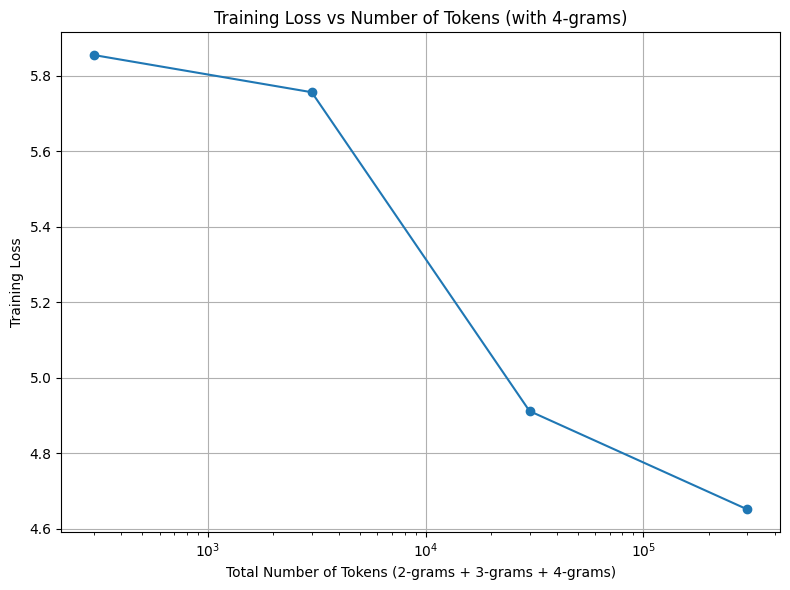

In [5]:
import matplotlib.pyplot as plt

# Total tokens = sum of 2-grams + 3-grams + 4-grams for each experiment
tokens = [300, 3000, 30000, 300000]
loss = [5.8550, 5.7565, 4.9119, 4.6514]

plt.figure(figsize=(8, 6))
plt.plot(tokens, loss, marker='o')
plt.xscale('log')
plt.xlabel('Total Number of Tokens (2-grams + 3-grams + 4-grams)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Number of Tokens (with 4-grams)')
plt.grid(True)
plt.tight_layout()
plt.show()


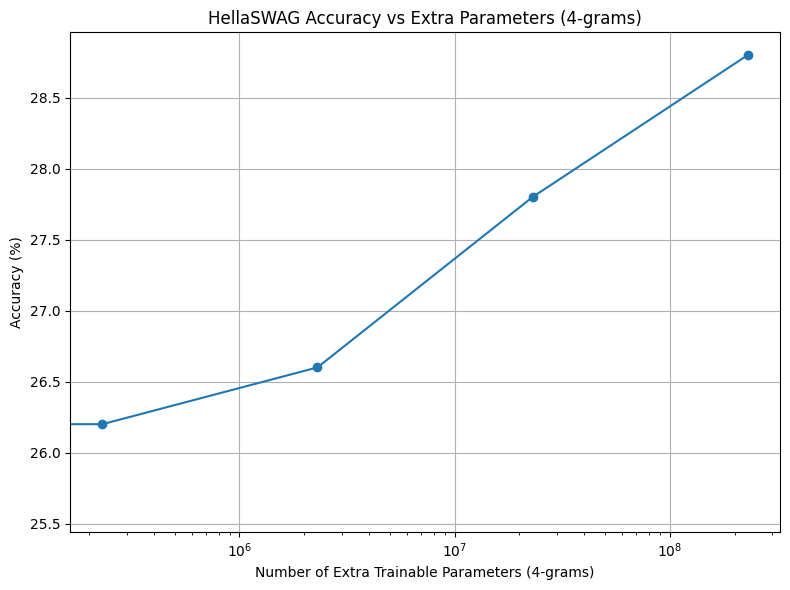

In [1]:
import matplotlib.pyplot as plt

extra_params = [0, 230400, 2304000, 23040000, 230400000]
accuracy = [25.6, 26.2, 26.6, 27.8, 28.8]

plt.figure(figsize=(8, 6))
plt.plot(extra_params, accuracy, marker='o')
plt.xscale('log')
plt.xlabel('Number of Extra Trainable Parameters (4-grams)')
plt.ylabel('Accuracy (%)')
plt.title('HellaSWAG Accuracy vs Extra Parameters (4-grams)')
plt.grid(True)
plt.tight_layout()
plt.show()


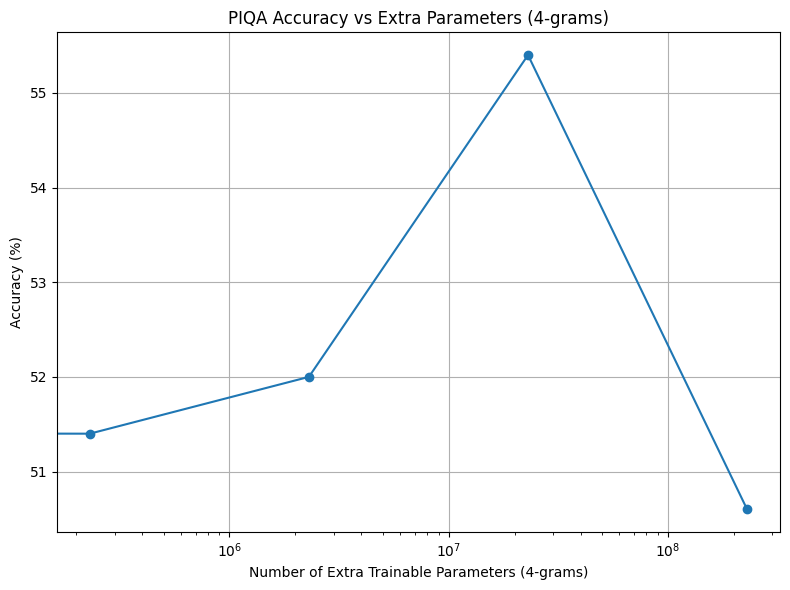

In [2]:
extra_params = [0, 230400, 2304000, 23040000, 230400000]
accuracy = [54.4, 51.4, 52.0, 55.4, 50.6]

plt.figure(figsize=(8, 6))
plt.plot(extra_params, accuracy, marker='o')
plt.xscale('log')
plt.xlabel('Number of Extra Trainable Parameters (4-grams)')
plt.ylabel('Accuracy (%)')
plt.title('PIQA Accuracy vs Extra Parameters (4-grams)')
plt.grid(True)
plt.tight_layout()
plt.show()


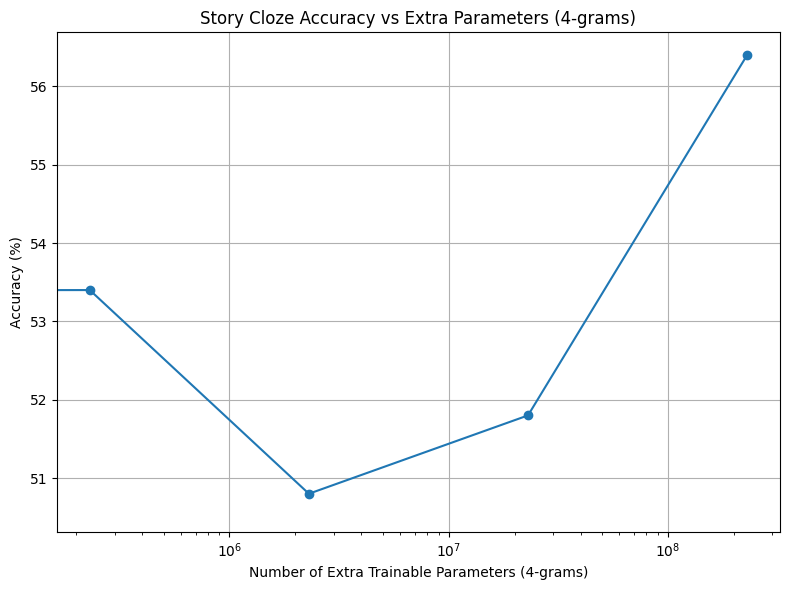

In [3]:
extra_params = [0, 230400, 2304000, 23040000, 230400000]
accuracy = [50.6, 53.4, 50.8, 51.8, 56.4]

plt.figure(figsize=(8, 6))
plt.plot(extra_params, accuracy, marker='o')
plt.xscale('log')
plt.xlabel('Number of Extra Trainable Parameters (4-grams)')
plt.ylabel('Accuracy (%)')
plt.title('Story Cloze Accuracy vs Extra Parameters (4-grams)')
plt.grid(True)
plt.tight_layout()
plt.show()


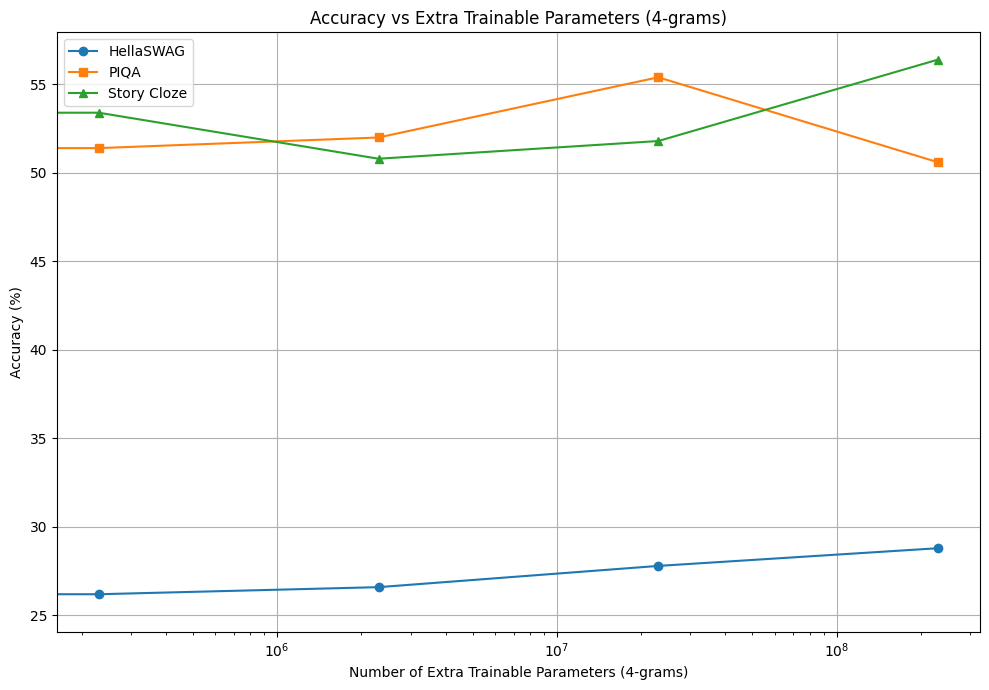

In [4]:
extra_params = [0, 230400, 2304000, 23040000, 230400000]

hellaswag = [25.6, 26.2, 26.6, 27.8, 28.8]
piqa = [54.4, 51.4, 52.0, 55.4, 50.6]
story_cloze = [50.6, 53.4, 50.8, 51.8, 56.4]

plt.figure(figsize=(10, 7))
plt.plot(extra_params, hellaswag, marker='o', label='HellaSWAG')
plt.plot(extra_params, piqa, marker='s', label='PIQA')
plt.plot(extra_params, story_cloze, marker='^', label='Story Cloze')

plt.xscale('log')
plt.xlabel('Number of Extra Trainable Parameters (4-grams)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Extra Trainable Parameters (4-grams)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


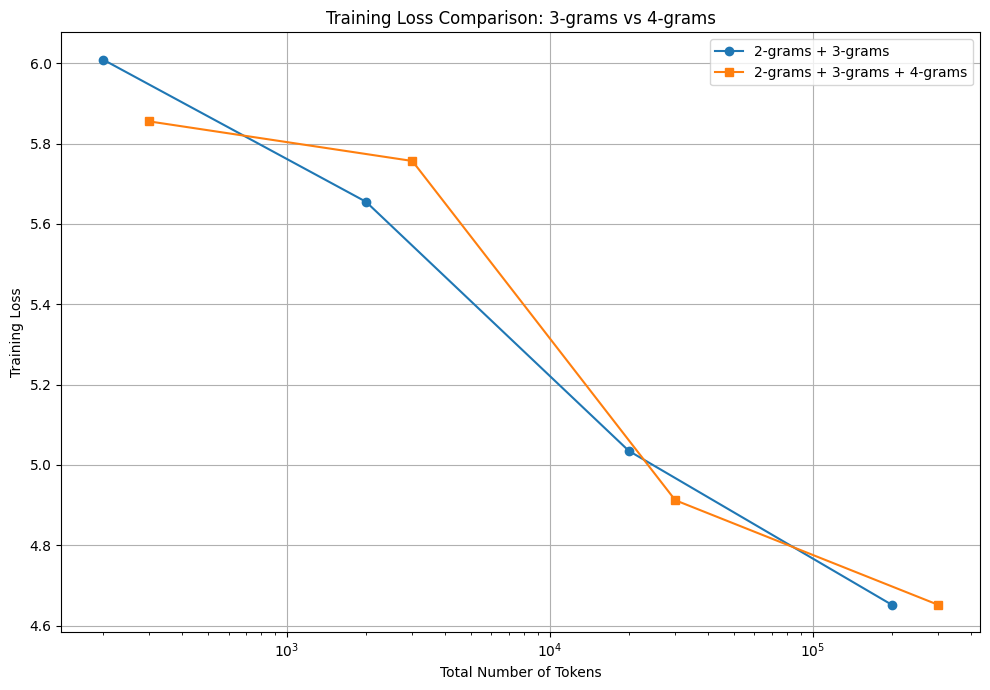

In [10]:
import matplotlib.pyplot as plt

# Shared total token counts (same steps in both experiments)
tokens = [200, 2000, 20000, 200000]       # for 2-grams + 3-grams
tokens_with_4gram = [300, 3000, 30000, 300000]  # for 2 + 3 + 4-grams

# Loss values from previous data
loss_3gram = [6.0089, 5.6549, 5.0345, 4.6514]
loss_4gram = [5.8550, 5.7565, 4.9119, 4.6514]

# Plot
plt.figure(figsize=(10, 7))
plt.plot(tokens, loss_3gram, marker='o', label='2-grams + 3-grams')
plt.plot(tokens_with_4gram, loss_4gram, marker='s', label='2-grams + 3-grams + 4-grams')

plt.xscale('log')
plt.xlabel('Total Number of Tokens')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison: 3-grams vs 4-grams')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
